**INTRO PLUS TITLE**

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

**PREAMBLE FOR WHAT OUR CODING IS ABOUT**

In [34]:
turkish_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00638/Acoustic%20Features.csv")
colnames(turkish_data) <- c("Class", "RMS_Energy_Mean", "Low_Energy_Mean", "Fluctuation_Mean", "Tempo_Mean", 
                            "MFCC_Mean1", "MFCC_Mean2", "MFCC_Mean3", "MFCC_Mean4", "MFCC_Mean5", "MFCC_Mean6",
                            "MFCC_Mean7", "MFCC_Mean8", "MFCC_Mean9", "MFCC_Mean10", "MFCC_Mean11", "MFCC_Mean12",
                            "MFCC_Mean13", "Roughness_Mean", "Roughness_Slope", "Zero_Crossing_Rate_Mean",
                            "Attack_Time_Mean", "Attack_Time_Slope", "Roll_Off_Mean", "Event_Density_Mean", "Pulse_Clarity_Mean",
                            "Brightness_Mean", "Spectral_Centroid_Mean", "Spectral_Spread_Mean", "Spectral_Skewness_Mean",
                            "Spectral_Kurtosis_Mean", "Spectral_Flatness_Mean", "Entropy_of_Spectrum_Mean", "Chromagram_Mean1",
                            "Chromagram_Mean2", "Chromagram_Mean3", "Chromagram_Mean4", "Chromagram_Mean5", "Chromagram_Mean6",
                            "Chromagram_Mean7", "Chromagram_Mean8", "Chromagram_Mean9", "Chromagram_Mean10", "Chromagram_Mean11",
                            "Chromagram_Mean12", "Harmonic_Change_Detection_Function_Mean", "Harmonic_Change_Detection_Function_Std",
                            "Harmonic_Change_Detection_Function_Slope", "Harmonic_Change_Detection_Function_Period_Freq", 
                            "Harmonic_Change_Detection_Function_Period_Amp", "Harmonic_Change_Detection_Function_Period_Entropy")
turkish_data <- mutate(turkish_data, Class = as_factor(Class))
check_amounts <- turkish_data |>
    group_by(Class) |>
    summarise(Count = n(),
              Mean_Low_Energy = mean(Low_Energy_Mean),
              Mean_Zero_Crossing_Rate = mean(Zero_Crossing_Rate_Mean),
              Mean_Attack_Time = mean(Attack_Time_Mean),
              Mean_Pulse_Clarity = mean(Pulse_Clarity_Mean),
              Mean_Spectral_Spread = mean(Spectral_Spread_Mean),
              Mean_Harmonic_Change_Detection_Function = mean(Harmonic_Change_Detection_Function_Mean))
check_amounts

Rows: 400 Columns: 51
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Class
dbl (50): _RMSenergy_Mean, _Lowenergy_Mean, _Fluctuation_Mean, _Tempo_Mean, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Class,Count,Mean_Low_Energy,Mean_Zero_Crossing_Rate,Mean_Attack_Time,Mean_Pulse_Clarity,Mean_Spectral_Spread,Mean_Harmonic_Change_Detection_Function
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
relax,100,0.55804,655.5579,0.03709,0.16760,3070.648,0.33593
happy,100,0.55370,1607.4490,0.02681,0.40804,3350.676,0.35477
sad,100,0.56421,930.8725,0.03841,0.16981,2856.778,0.34154
angry,100,0.53847,795.1300,0.02291,0.25210,3051.477,0.28061


**INFO ABOUT WRANGLING DATA + HOW WE WILL SPLIT IT**

In [3]:
set.seed(6969)

turkish_split <- initial_split(turkish_data, prop = 0.8, strata = Class)
turkish_training <- training(turkish_split)
turkish_testing <- training(turkish_split)

**VISUALIZATION EXPLANATION**

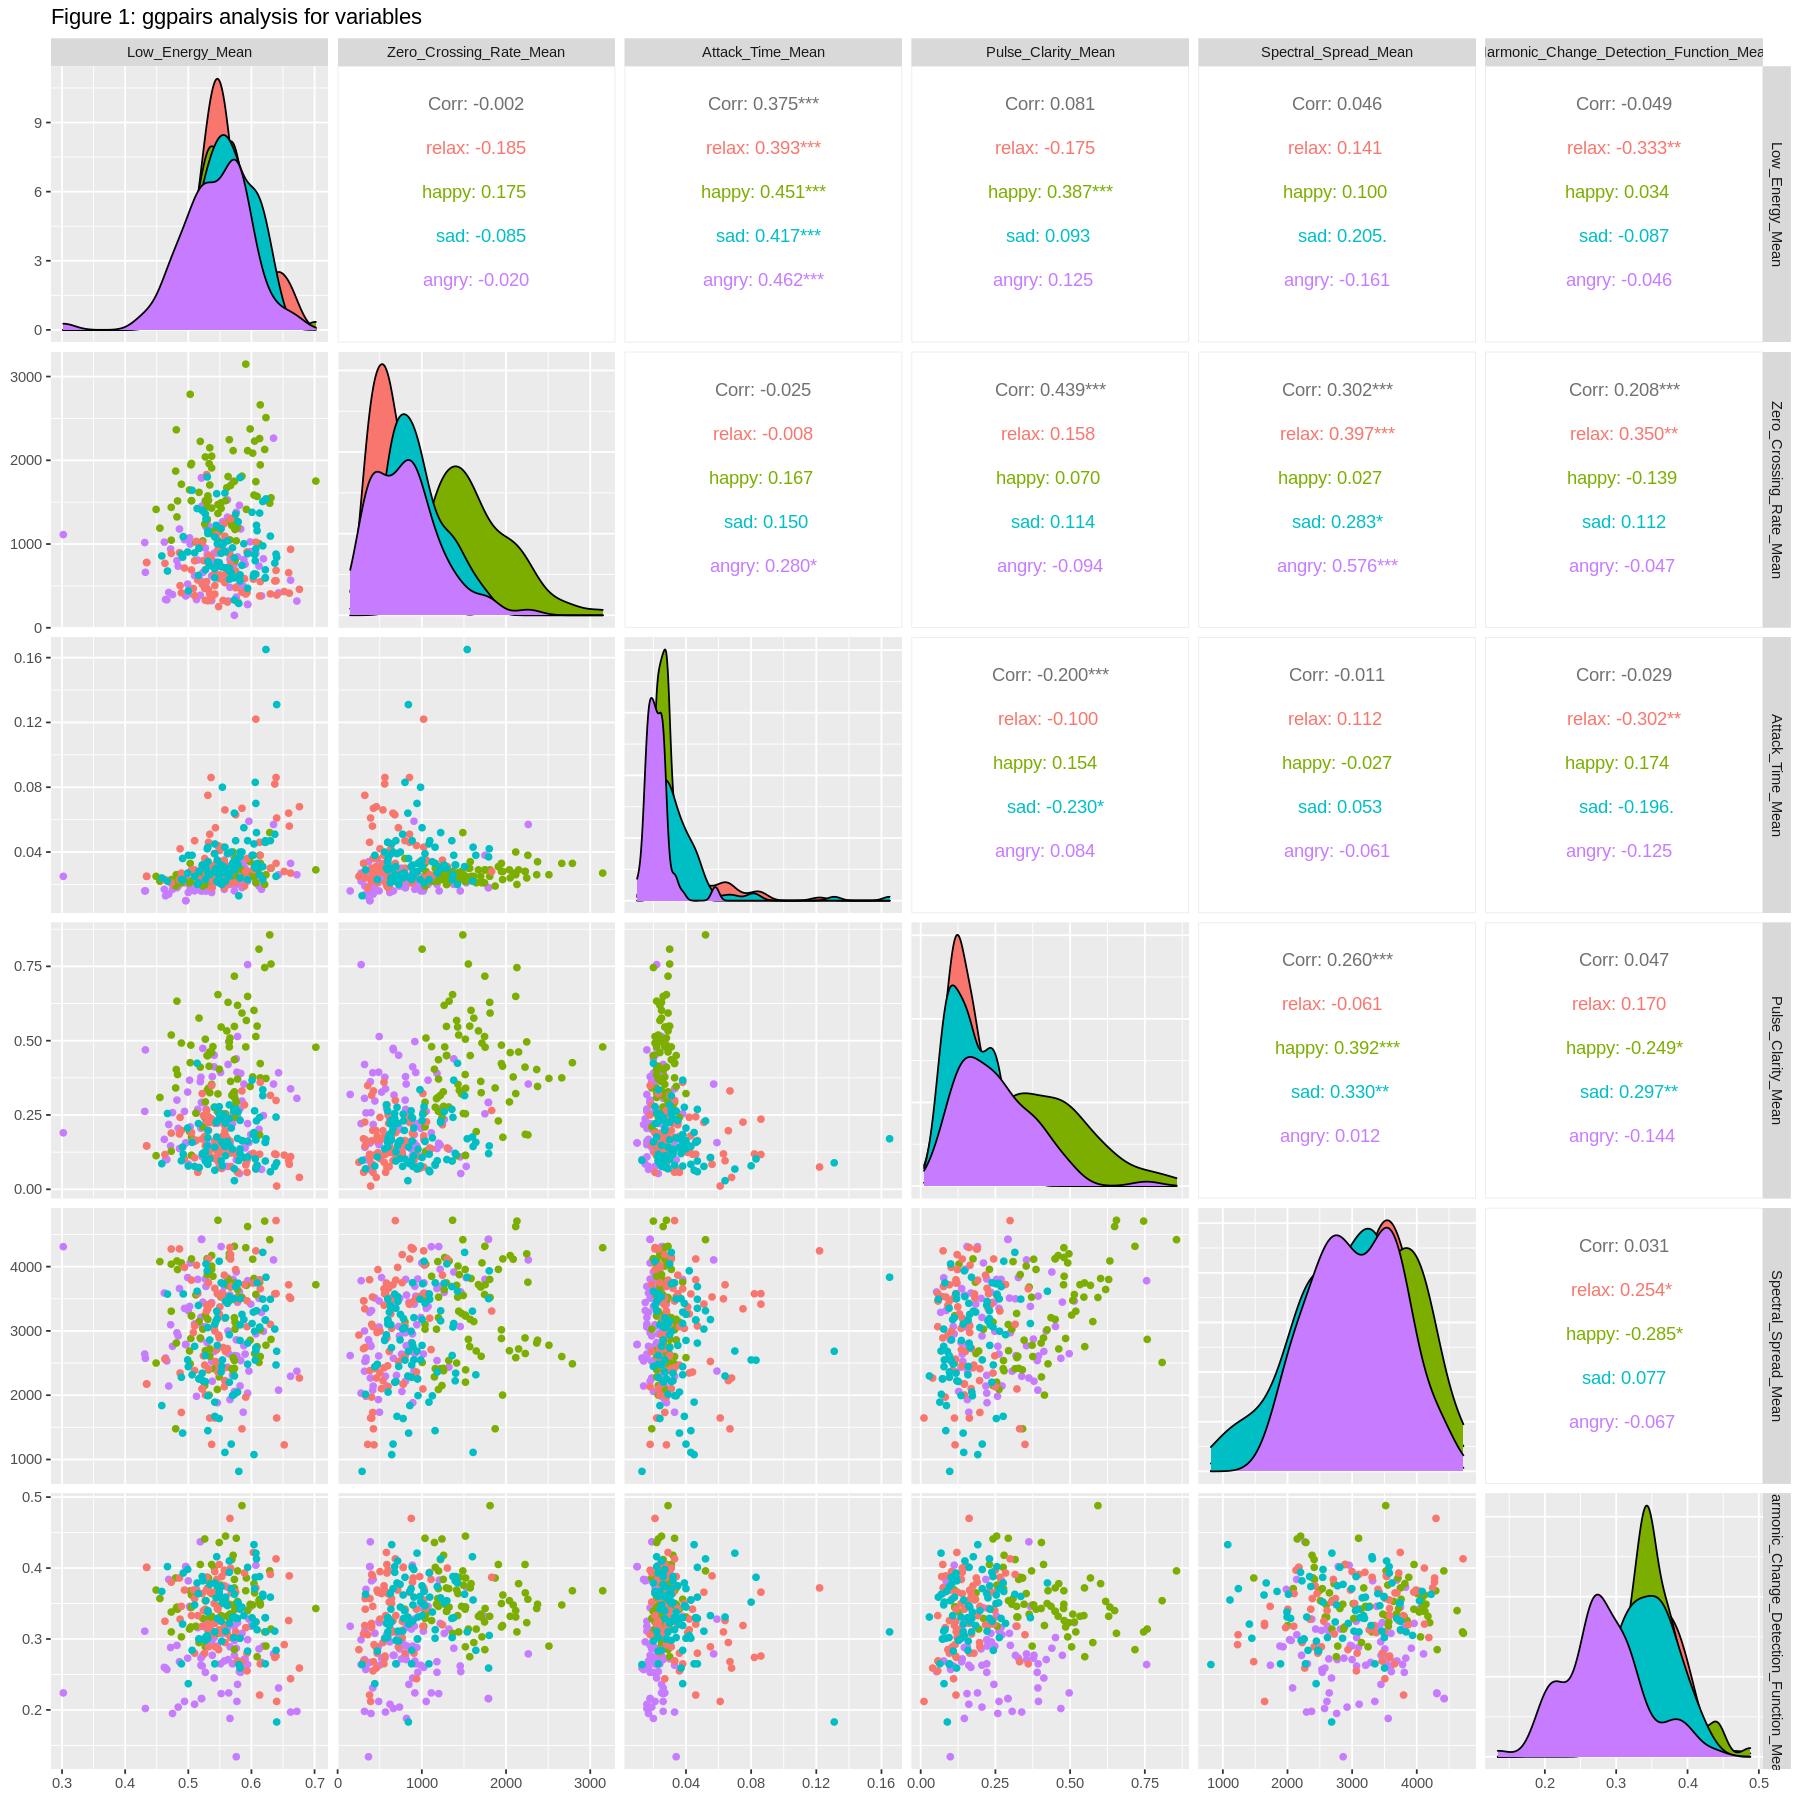

In [17]:
options(repr.plot.width = 15, repr.plot.height = 15)

turkish_small <- turkish_training |>
    select(Class, Low_Energy_Mean, Zero_Crossing_Rate_Mean, Attack_Time_Mean, 
           Pulse_Clarity_Mean, Spectral_Spread_Mean, Harmonic_Change_Detection_Function_Mean)
turkish_plot <- ggpairs(data = turkish_small, columns = 2:7, ggplot2::aes(colour=Class),
                        ggplot2::labs(tag = "Figure 1: ggpairs analysis for variables"))
turkish_plot

**CROSS VALIDATION**

In [5]:
set.seed(6969)

turkish_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

turkish_recipe <- recipe(Class ~ Low_Energy_Mean + Zero_Crossing_Rate_Mean + Attack_Time_Mean + 
                         Pulse_Clarity_Mean + Spectral_Spread_Mean + Harmonic_Change_Detection_Function_Mean,
                         data = turkish_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

turkish_vfold <- vfold_cv(turkish_training, v = 8, strata = Class)

gridvals <- tibble(neighbors = seq(from = 1, to = 80, by = 1))

accuracies <- workflow() |>
    add_recipe(turkish_recipe) |>
    add_model(turkish_tune) |>
    tune_grid(resamples = turkish_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

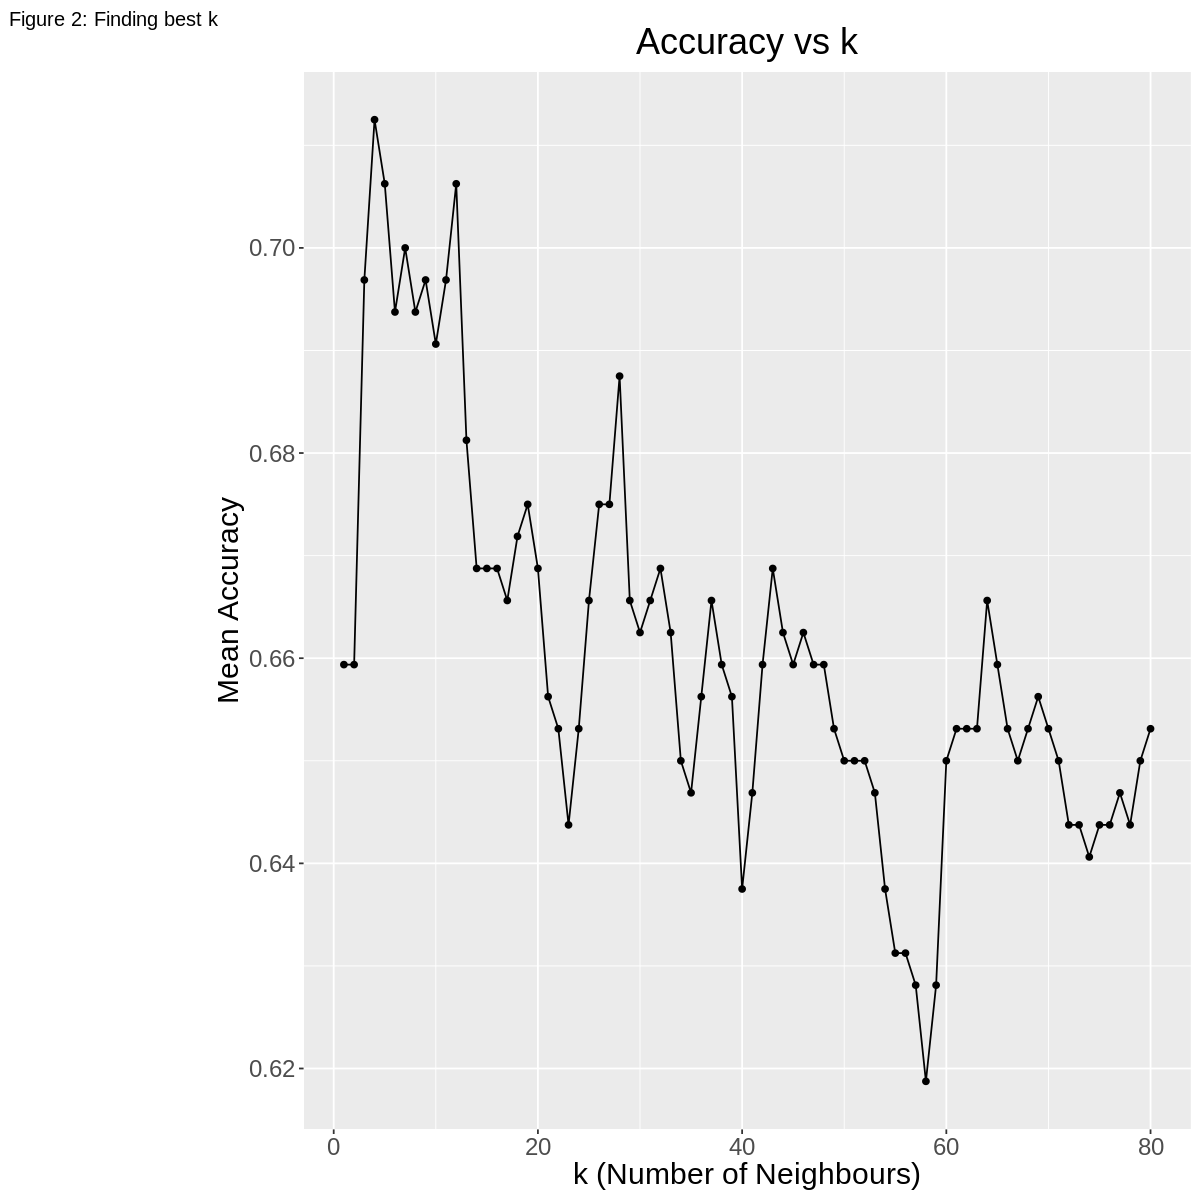

In [30]:
options(repr.plot.width = 10, repr.plot.height = 10)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "k (Number of Neighbours)", y = "Mean Accuracy", tag = "Figure 2: Finding best k") +
    ggtitle("Accuracy vs k") +
    theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5), plot.tag = element_text(size = 12))

accuracy_vs_k

k_min <- accuracies |>
    arrange(desc(mean)) |>
    slice(1) |>
    select(neighbors) |>
    pull()

**GRAPH EXPLINATION**

In [7]:
set.seed(6969)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
    set_engine("kknn") |>
    set_mode("classification")

turkish_fit <- workflow() |>
    add_recipe(turkish_recipe) |>
    add_model(knn_spec) |>
    fit(data = turkish_training)

turkish_predictions <- predict(turkish_fit, turkish_testing) |>
    bind_cols(turkish_testing)

turkish_accuracy <- turkish_predictions |>
    metrics(truth = Class, estimate = .pred_class) |>
    filter(.metric == "accuracy")

turkish_mat <- turkish_predictions |>
    conf_mat(truth = Class, estimate = .pred_class)

turkish_accuracy
turkish_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.875


          Truth
Prediction relax happy sad angry
     relax    70     2  11     2
     happy     1    76   2     1
     sad       6     2  62     5
     angry     3     0   5    72

**TALK ABOUT THE MODEL**

**CONCLUSION**